<a href="https://colab.research.google.com/github/Metaurus/AI-Stock-Prediction/blob/main/modelLSTM_historicaldata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  2 of 2 completed


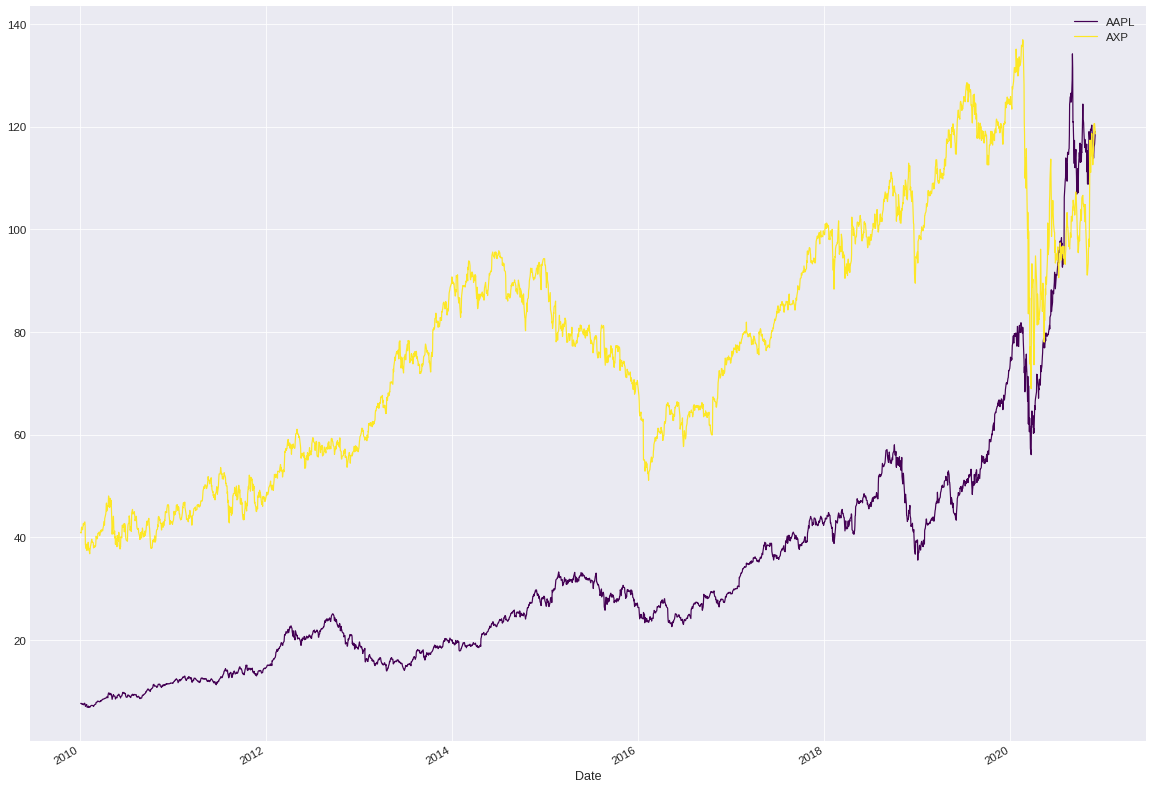

In [5]:
#Import the Yahoo finance to get the stock data
!pip install yfinance
import yfinance as yf

#Import the plotting library
import matplotlib.pyplot as plt

import pickle
import pandas as pd
import csv
import numpy as np

#Ticker is used for the series of stocks that we are intrested in
stocks = ["AXP","AAPL"]


#,"AAPL","BA","CSCO","CVX","XOM","GE","HD","IBM",
  #        "INTC","JNJ","KO","JPM","MCD","MMM","MRK","MSFT",
  #        "NKE","PFE","PG","UNH","VZ","V","WMT","DIS"]

#Get the data of the stocks
df = yf.download(stocks, start = '2010-01-01', end = '2020-12-01')


#Ordered the stocks alphabetically and saved them in a csv file
df.stack().reset_index().rename(index=str, columns={"level_1": "Symbol"}).sort_values(['Symbol','Date'])
df.to_csv('Stocks1.csv')

#Plot the close price
df1 = df.Close
df1.to_pickle("df_dow_jones.pkl")
df3 = pd.read_pickle("df_dow_jones.pkl")
df3.head()

plt.style.use('seaborn-dark')

df.Close.plot(cmap= "viridis", figsize= (20,15))
plt.grid()
plt.show()

In [6]:
!pip install matplotlib pandas nltk textblob 

import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from urllib.request import urlopen
from urllib.request import Request
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
from collections import Counter


n = 100
tickers = ["AXP"]

#"AAPL","BA","CSCO","CVX","XOM","GE","HD","IBM",
 #         "INTC","JNJ","KO","JPM","MCD","MMM","MRK","MSFT",
  #        "NKE","PFE","PG","UNH","VZ","V","WMT","DIS"]

# Get Data
finviz_url = 'https://finviz.com/quote.ashx?t='
news_tables = {}

def preprocess(headline):
    text= headline.lower()
    text = re.sub('https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', text)
    text = re.sub('\$[a-zA-Z0-9]*', ' ', text)
    text = re.sub('[^a-zA-Z]', ' ', text)
    return text


for ticker in tickers:
    url = finviz_url + ticker
    req = Request(url=url,headers={'user-agent': 'my-app/0.0.1'}) 
    resp = urlopen(req)    
    html = BeautifulSoup(resp, features="lxml")
    news_table = html.find(id='news-table')
    news_tables[ticker] = news_table

try:
    for ticker in tickers:
        df = news_tables[ticker]
        df_tr = df.findAll('tr')
    
        print ('\n')
        print ('Recent News Headlines for {}: '.format(ticker))
        
        for i, table_row in enumerate(df_tr):
            a_text = table_row.a.text
            td_text = table_row.td.text
            td_text = td_text.strip()
            print(preprocess(a_text),'(',td_text,')')
            if i == n-1:
                break
except KeyError:
    pass

parsed_news = []
for file_name, news_table in news_tables.items():
    for x in news_table.findAll('tr'):
        text = x.a.get_text()
        date_scrape = x.td.text.split()

        if len(date_scrape) == 1:
            time = date_scrape[0]
            
        else:
            date = date_scrape[0]
            time = date_scrape[1]
        
        ticker = file_name.split('_')[0]
        
        parsed_news.append([ticker, date, time, text])
        
all_words = [word for headline in preprocess(text) for word in headline.split()]
print('The number of all words: ', len(all_words))

counts = Counter(all_words)
print('The number of unique words: ', len(counts))

bow = sorted(counts, key=counts.get, reverse=True)
print('Top 40 frequent words: ', bow[:40])


analyzer = SentimentIntensityAnalyzer()

new_words = {
    'crushes': -4,
    'beats': 4,
    'misses': -3,
    'trouble': -2,
    'falls': -3,
    'investigating': -3,
    'investigation': -3,
}

analyzer.lexicon.update(new_words)

columns = ['Ticker', 'Date', 'Time', 'Headline']
news = pd.DataFrame(parsed_news, columns=columns)
scores = news['Headline'].apply(analyzer.polarity_scores).tolist()

df_scores = pd.DataFrame(scores)
news = news.join(df_scores, rsuffix='_right')


# View Data 
news['Date'] = pd.to_datetime(news.Date).dt.date

unique_ticker = news['Ticker'].unique().tolist()
news_dict = {name: news.loc[news['Ticker'] == name] for name in unique_ticker}

values = []
for ticker in tickers: 
    dataframe = news_dict[ticker]
    dataframe = dataframe.set_index('Ticker')
    dataframe = dataframe.drop(columns = ['Headline'])
    print ('\n')
    print (dataframe.head())
    
    mean = round(dataframe['compound'].mean(), 2)
    values.append(mean)
    
df = pd.DataFrame(list(zip(tickers, values)), columns =['Ticker', 'Mean Sentiment']) 
df = df.set_index('Ticker')
df = df.sort_values('Mean Sentiment', ascending=False)
print ('\n')
print (df)
df.to_pickle("APX_with_time_and_sentiment.pkl")



[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Recent News Headlines for AXP: 
amex  axp  provides a bouquet of offers for its card members ( Jan-08-21 01:26PM )
the top    warren buffett stocks ( 12:34PM )
   best consumer finance stocks to buy now ( 09:13AM )
feds investigating american express over business payment cards ( 08:00AM )
amex faces three pronged federal investigation over card sales practices  wsj ( 06:10AM )
day one launch of collection sites covid    testing site at town of east hampton model of success ( Jan-07-21 04:54PM )
top stock reports for unitedhealth  netflix   caterpillar ( 12:05PM )
  stocks to gain traction from fintech evolution in      ( 09:50AM )
billionaire andreas halvorsens top    stock picks ( Jan-06-21 10:53AM )
collection sites launches covid    testing site at town of east hamptons town hall campus  medivolve inc  name change becomes effective today ( 07:30AM )
   bi

Epoch 1/8
18/18 - 2s - loss: 0.0504 - val_loss: 0.0912
Epoch 2/8
18/18 - 0s - loss: 0.0028 - val_loss: 0.0034
Epoch 3/8
18/18 - 0s - loss: 0.0061 - val_loss: 0.0066
Epoch 4/8
18/18 - 0s - loss: 0.0038 - val_loss: 0.0075
Epoch 5/8
18/18 - 0s - loss: 0.0024 - val_loss: 0.0034
Epoch 6/8
18/18 - 0s - loss: 0.0019 - val_loss: 0.0026
Epoch 7/8
18/18 - 0s - loss: 0.0013 - val_loss: 0.0018
Epoch 8/8
18/18 - 0s - loss: 0.0010 - val_loss: 0.0015
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 200)               164800    
_________________________________________________________________
dropout_8 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 201       
Total params: 165,001
Trainable params: 165,001
Non-trainable params: 0
____

INFO:tensorflow:Assets written to: modelLSTM.model/assets


INFO:tensorflow:Assets written to: modelLSTM.model/assets


Train Mean Absolute Error: 0.0174334
Train Root Mean Squared Error: 0.022218706
Test Mean Absolute Error: 0.026813062
Test Root Mean Squared Error: 0.03915089


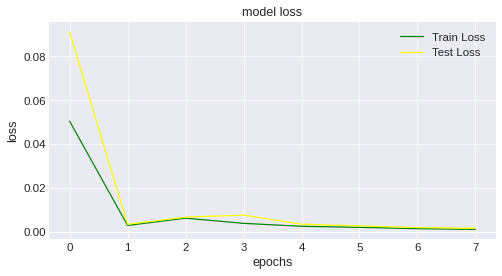

ValueError: ignored

In [14]:
import torch


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)

import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')

import warnings
warnings.filterwarnings('ignore')

from time import time

import matplotlib.ticker as tkr

from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
    
import math

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

result= pd.read_pickle("df_dow_jones.pkl")

# original time serie (Y)
y = result.AXP.values 
y = y.astype('float32')
y = np.reshape(y, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
y = scaler.fit_transform(y)



# training and testing settings (size)
percent_of_training = 0.8
train_size = int(len(y) * percent_of_training)
test_size = len(y) - train_size
# 
train_y, test_y = y[0:train_size,:], y[train_size:len(y),:]


def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)



look_back = 5


# features of the original time serie (y)
X_train_features_1, y_train = create_dataset(train_y, look_back)
X_test_features_1, y_test = create_dataset(test_y, look_back)




# join the all the features in one
## reshape arrays
X_train_features = np.reshape(X_train_features_1, (X_train_features_1.shape[0], 1, X_train_features_1.shape[1]))
X_test_features  = np.reshape(X_test_features_1, (X_test_features_1.shape[0], 1, X_test_features_1.shape[1]))

model = Sequential()
model.add(LSTM(200, input_shape=(X_train_features.shape[1], X_train_features.shape[2])))
model.add(Dropout(0.20))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train_features,y_train, epochs=8, batch_size=125, validation_data=(X_test_features, y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=8)], verbose=2, shuffle=False)

model.summary()


train_predict = model.predict(X_train_features)
test_predict  = model.predict(X_test_features)

model.save('modelLSTM.model')


#train_predict = scaler.inverse_transform(train_predict)
#Y_train = scaler.inverse_transform(y_train)
#test_predict = scaler.inverse_transform(test_predict)
#Y_test = scaler.inverse_transform(y_test)


print('Train Mean Absolute Error:', mean_absolute_error(np.reshape(y_train,(y_train.shape[0],1)), train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(np.reshape(y_train,(y_train.shape[0],1)), train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(np.reshape(y_test,(y_test.shape[0],1)), test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(np.reshape(y_test,(y_test.shape[0],1)), test_predict[:,0])))


plt.figure(figsize=(8,4))
plt.style.use('seaborn-dark')

plt.plot(history.history['loss'], label='Train Loss',color="green")
plt.plot(history.history['val_loss'], label='Test Loss',color = "yellow")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.grid()

plt.show();

time_y_train1 = pd.DataFrame(data = train_y, index = result[0:train_size].index,columns= [""])
time_ytrain = time_y_train1.drop_duplicates()
time_y_test1  = pd.DataFrame(data = test_y, index = result[train_size:].index,columns= [""])
time_y_test = time_y_test1.drop_duplicates()

time_y_train_prediction1 = pd.DataFrame(data = train_predict, index = time_y_train[8:].index,columns= [""])
time_y_train_prediction = time_y_prediction1.drop_duplicates()

time_y_test_prediction1  = pd.DataFrame(data = test_predict, index = time_y_test[8:].index,columns= [""])
time_y_test_prediction = time_y_test1.drop_duplicates()

plt.style.use('seaborn-dark')
plt.figure(figsize=(15,10))

plt.plot(time_y_train,label = "training",color ="green",marker='.')
plt.plot(time_y_test,label = "test",marker='.')
plt.plot(time_y_train_prediction,color="red",label = "prediction")
plt.plot(time_y_test_prediction,color="red")
plt.title("LSTM fit of Amex Stock Market Prices",size = 20)
plt.tight_layout()
sns.despine(top=True)
plt.ylabel('', size=15)
plt.xlabel('', size=15)
plt.legend(fontsize=15)
plt.grid()

plt.show();